In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

# Importation du fichier kaggle

In [9]:
df_train_kaggle = pd.read_csv('../data/kaggle.csv')
df_train_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [5]:
df_train_kaggle.Emotion.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

Text(-18.075000000000003, 0.5, 'Count')

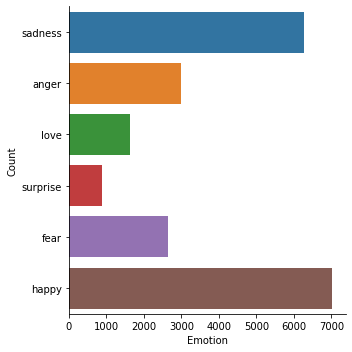

In [6]:
sns.catplot(y='Emotion', kind='count', data=df_train_kaggle) 
plt.xlabel("Emotion") 
plt.ylabel("Count")

In [7]:
categories = df_train_kaggle.Emotion.unique()
categories

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [24]:
df_train, df_test= train_test_split(df_train_kaggle, test_size=0.20 ,random_state=42)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vect = CountVectorizer(strip_accents='ascii', lowercase=True, stop_words='english' ,max_df=0.9, min_df=2)
# On commence avec un preprocessing minimal (lower, token = word)
X_train_counts = count_vect.fit_transform(df_train.Text)
print(f"dimension de la matrice de comptage: {X_train_counts.shape}")


dimension de la matrice de comptage: (17167, 7703)


In [10]:
def visualize_word_freq(input_data,max_words,title_pre,tfidf=False):
    """ 
    Input data should be a list of docs.
    Each doc is represented by one whole string (with preprocessing, eg.remove markups)    
    """
    # Plot configuration
    plt.style.use("ggplot")
    plt.rcParams['axes.titlesize'] = 32
    plt.rcParams['figure.figsize'] = (20.0, 5.0)
    plt.rcParams['xtick.labelsize'] = 10
    
    if tfidf:
        vectorizer = TfidfVectorizer(max_features=max_words,stop_words='english',use_idf=True, max_df=0.9, min_df=2)
        TITLE = title_pre+" - "+"Most Freq Words (TFIDF)"
    else:
        vectorizer = CountVectorizer(max_features=max_words,stop_words='english', max_df=0.9, min_df=2)
        TITLE = title_pre+" - "+"Most Freq Words"
        
    mat = vectorizer.fit_transform(input_data)
    
    pd.DataFrame(mat.sum(axis=0).T,
             index=vectorizer.get_feature_names_out(),
             columns=['freq']).sort_values(by='freq',
                                           ascending=False).plot(kind='bar',title=TITLE)

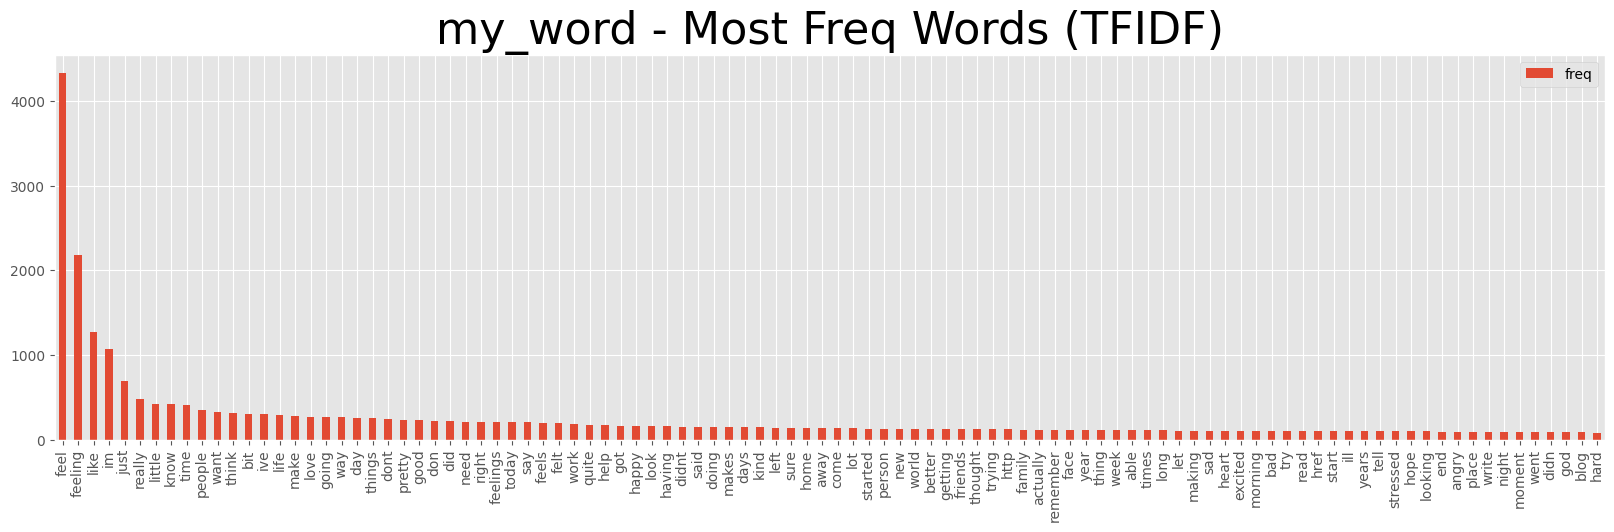

In [26]:
sw = ['english' ]
visualize_word_freq(df_train.Text,100, 'my_word', True)

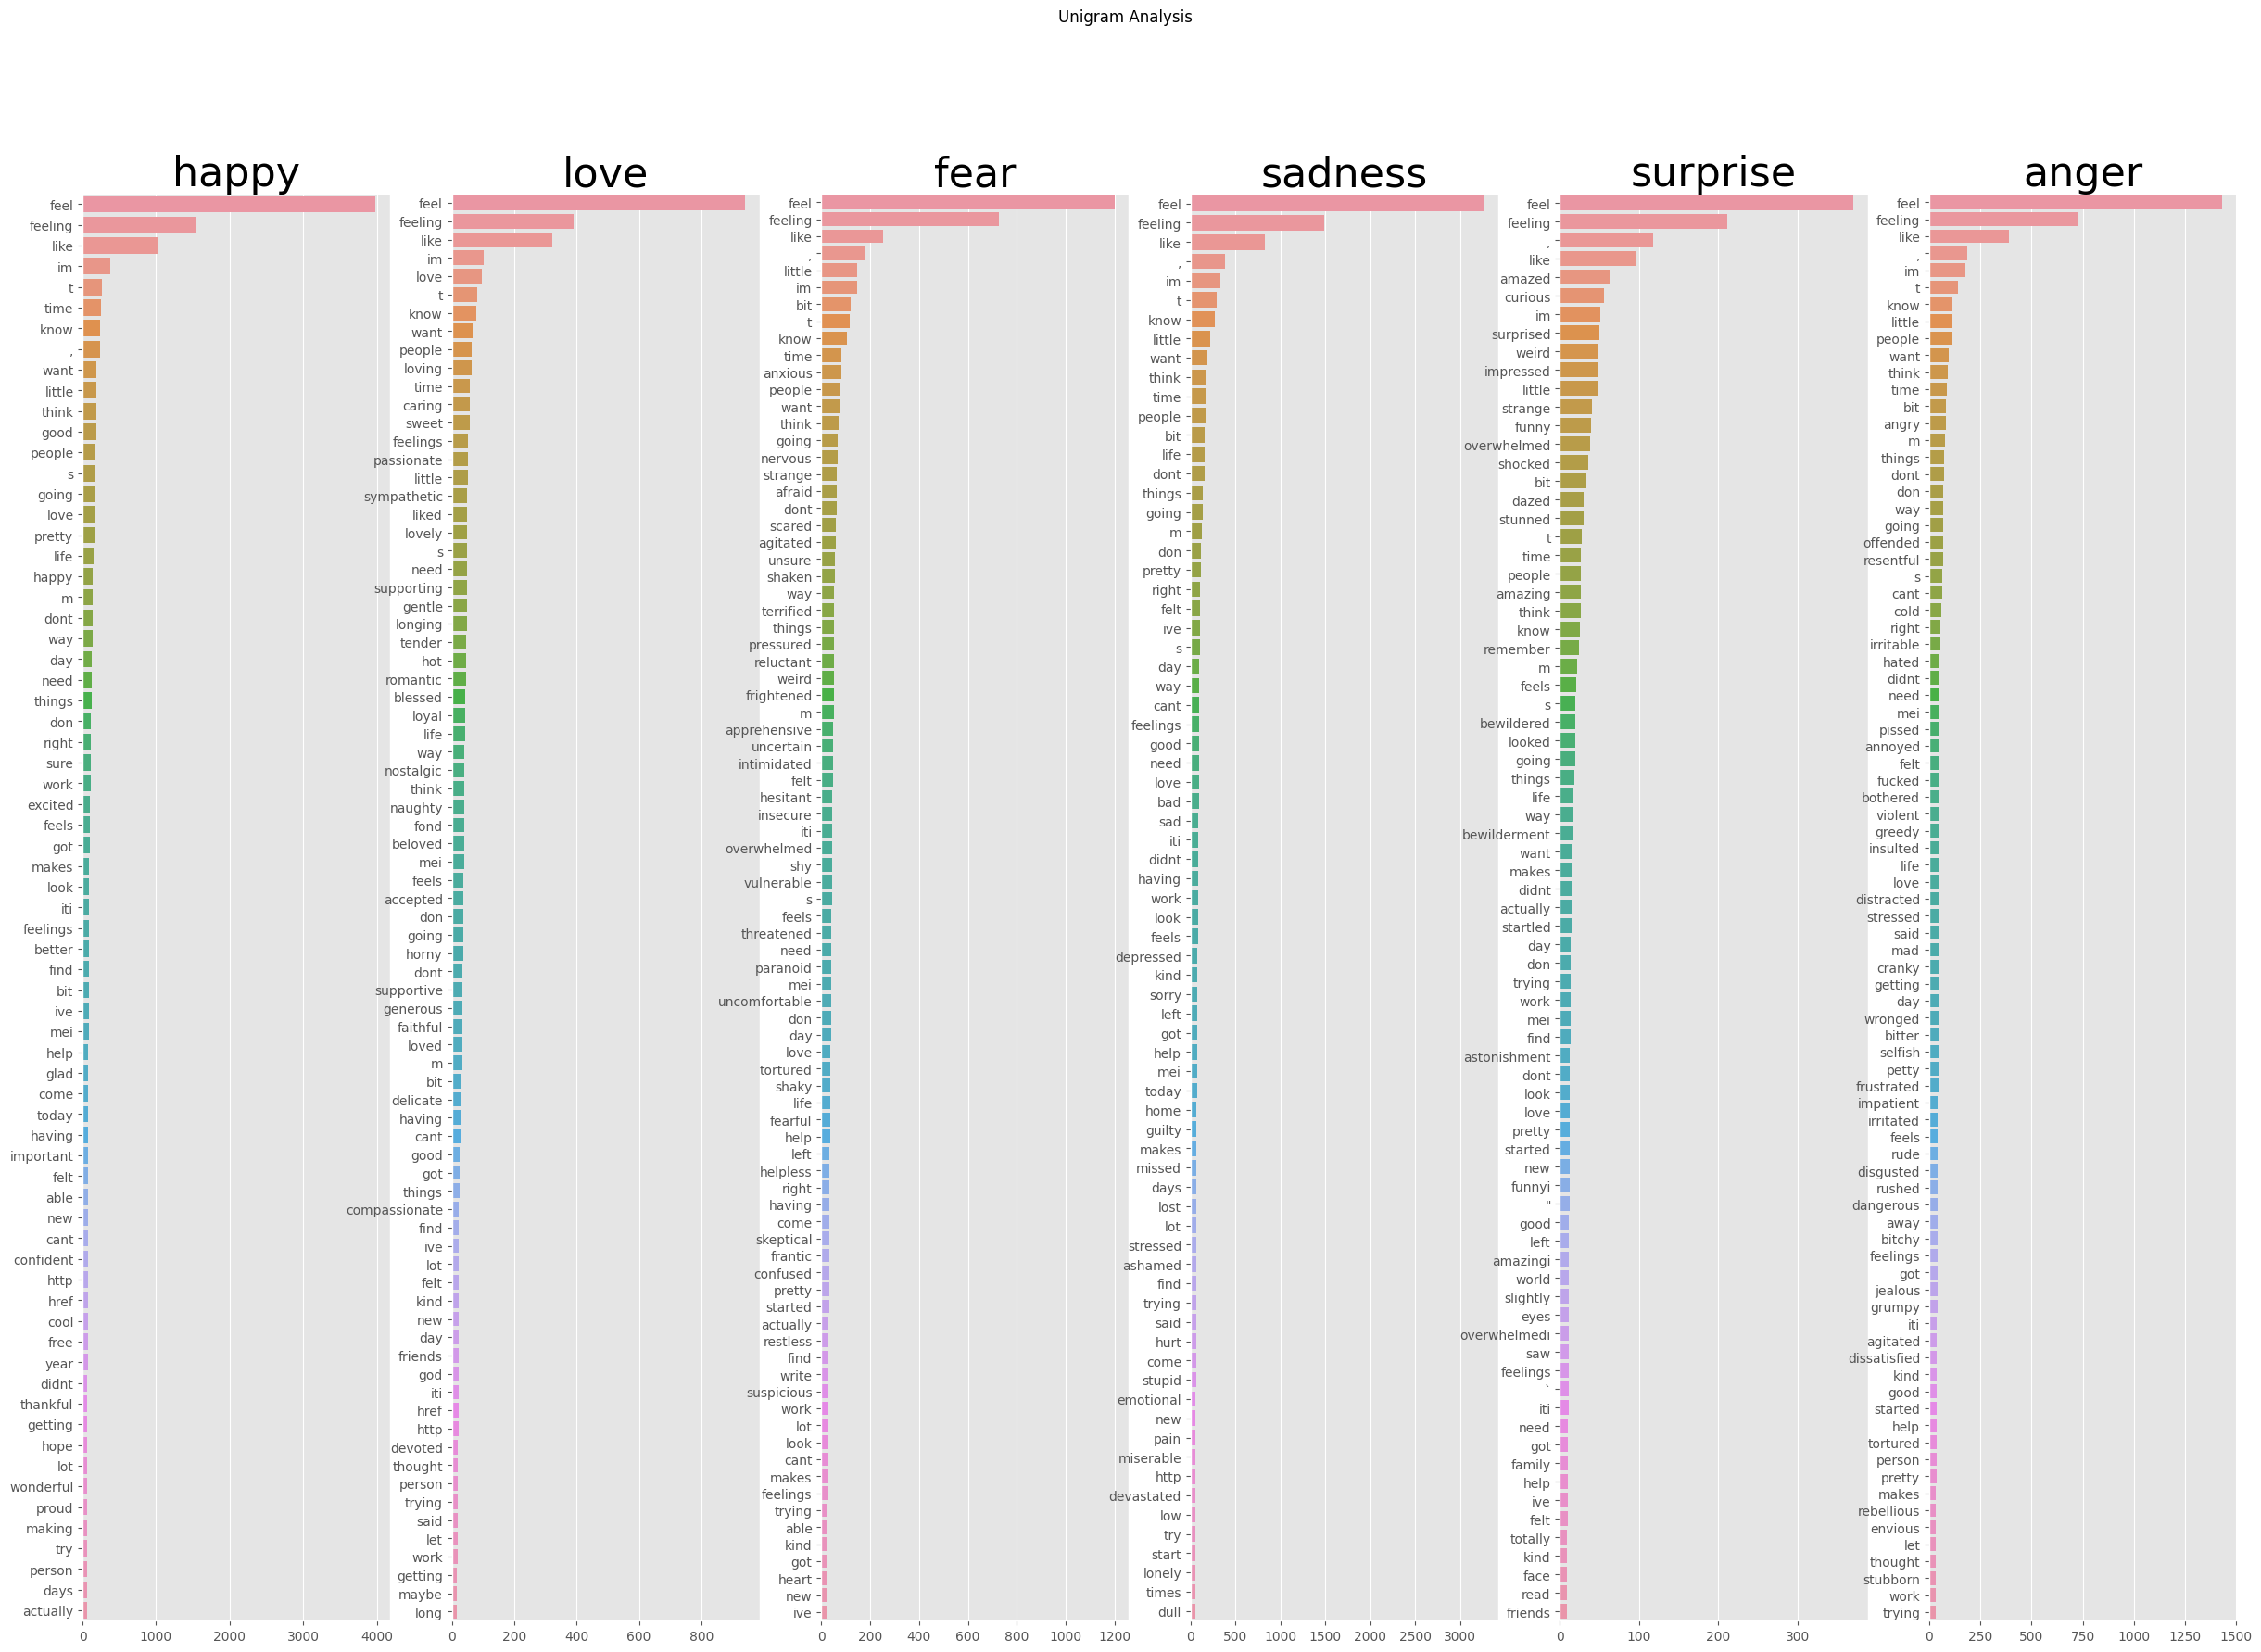

In [12]:
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

fig, axes = plt.subplots(1,len(df_train['Emotion'].unique()), figsize=(30,20))
fig.suptitle('Unigram Analysis')

for index,emotion in enumerate(df_train['Emotion'].unique()):
    dct=defaultdict(int) 
    curdf=df_train[df_train['Emotion']==emotion]
    allwordsarr=curdf['Text'].str.cat().split()
    counter=Counter(allwordsarr)
    most=counter.most_common()
    x=[]
    y=[]
    for word,count in most[:200]:
        if (word.lower() not in STOP_WORDS):
            x.append(word)
            y.append(count)
    sns.barplot(ax=axes[index],x=y,y=x)
    axes[index].set_title(str(emotion))

In [13]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_counts, df_train.Emotion)



In [14]:
X_test_counts = count_vect.transform(df_test.Text)
predicted = clf.predict(X_test_counts)
predicted

array(['happy', 'anger', 'happy', ..., 'anger', 'anger', 'happy'],
      dtype='<U8')

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(df_test.Emotion, predicted)

0.8266542404473439

In [16]:
from sklearn import metrics
print(metrics.classification_report(df_test.Emotion, predicted))

              precision    recall  f1-score   support

       anger       0.88      0.77      0.82       617
        fear       0.81      0.75      0.78       531
       happy       0.82      0.92      0.87      1381
        love       0.81      0.55      0.65       318
     sadness       0.82      0.92      0.87      1277
    surprise       0.80      0.31      0.45       168

    accuracy                           0.83      4292
   macro avg       0.82      0.70      0.74      4292
weighted avg       0.83      0.83      0.82      4292



In [17]:
docs_new = ['God is love', 'fuck the world is not enough', "I am very sorry for you lost","i win a lot today, I am the best"]
X_new_counts = count_vect.transform(docs_new)
predicted = clf.predict(X_new_counts)
for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, category))

'God is love' => happy
'fuck the world is not enough' => sadness
'I am very sorry for you lost' => sadness
'i win a lot today, I am the best' => happy


In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

NameError: name 'MultinomialNB' is not defined

In [24]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__strip_accents': [None, 'ascii'],
    'vect__stop_words': ["english", None],
    'vect__max_df': [1, 0.9,0.8,0.7],
}

In [25]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
# on ne l'entraine que sur une partie du jeu de données
gs_clf = gs_clf.fit(df_train_kaggle.Text, df_train_kaggle.Emotion)

In [21]:
print(gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

0.7549717836352251
vect__max_df: 0.9
vect__ngram_range: (1, 1)
vect__stop_words: 'english'
vect__strip_accents: None


In [22]:
predicted_grid = gs_clf.predict(df_train_kaggle.Text)

In [23]:
print(metrics.classification_report(df_train_kaggle.Emotion, predicted_grid))

              precision    recall  f1-score   support

       anger       0.97      0.87      0.92      2993
        fear       0.94      0.85      0.89      2652
       happy       0.87      0.98      0.92      7029
        love       0.98      0.62      0.76      1641
     sadness       0.88      0.98      0.92      6265
    surprise       0.99      0.46      0.62       879

    accuracy                           0.90     21459
   macro avg       0.94      0.79      0.84     21459
weighted avg       0.91      0.90      0.89     21459



In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
parameters = {
    'vect__max_df': [0.9],
    'vect__ngram_range': [(1, 1)],
    'vect__stop_words': ['english'],
    'vect__strip_accents': [None],
}

In [41]:
import xgboost as xgb

In [42]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('xgb', xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              use_label_encoder=False,
              validate_parameters=1, verbosity=None,tree_method='gpu_hist')),
])

In [43]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
df_train_enc = LabelEncoder().fit_transform(df_train.Emotion)
df_test_enc = LabelEncoder().fit_transform(df_test.Emotion)


In [44]:
# on ne l'entraine que sur une partie du jeu de données
gs_clf = text_clf.fit(df_train.Text, df_train_enc)

In [45]:
predicted_grid = gs_clf.predict(df_test.Text)
predicted_grid

array([2, 0, 4, ..., 0, 0, 3], dtype=int64)

In [46]:
from sklearn import metrics
print(metrics.classification_report(df_test_enc, predicted_grid))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       617
           1       0.87      0.86      0.87       531
           2       0.86      0.92      0.89      1381
           3       0.77      0.83      0.80       318
           4       0.95      0.90      0.92      1277
           5       0.76      0.75      0.75       168

    accuracy                           0.89      4292
   macro avg       0.86      0.85      0.85      4292
weighted avg       0.89      0.89      0.89      4292

